<a href="https://colab.research.google.com/github/dots13/fake_news_detection_Salvador/blob/master/TF-IDF/Tf_IDF_boosting_models_OPTUNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip3 install catboost
!pip3 install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.3 MB/s eta 0:00:00


In [25]:
import pandas as pd
import numpy as np
from google.colab import drive

pd.set_option('max_colwidth', 400)

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold

import xgboost as xgb
import lightgbm as lgb
#from catboost import CatBoostClassifier
import optuna

In [3]:
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/files/fake-news'

Mounted at /content/gdrive


In [4]:
!ls gdrive/MyDrive/files/fake-news/preprocessed-data-for-modelling

test.json  train.json


In [22]:

def eval_report(y_test, y_pred):
    print(f'Accuracy score:{metrics.accuracy_score(y_test, y_pred):.4f}')
    print(f'Balanced accuracy score:{metrics.balanced_accuracy_score(y_test, y_pred):.4f}')
    print(f'F-1 score:{metrics.f1_score(y_test, y_pred):.4f}')
    print(f'ROC-AUC score:{metrics.roc_auc_score(y_test, y_pred):.4f}')

In [21]:
### Function for confusion matrix visualization
def confusion_matrix_visualization(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = [f'{value:.0f}' for value in cf_matrix.flatten()]
    group_percentages = [f'{value:.2%}' for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    fig, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    fig.show()

In [5]:
df_train = pd.read_csv(path + '/train_test_anastasiia/train_clean.csv')
df_test = pd.read_csv(path + '/train_test_anastasiia/test_clean.csv')

In [6]:
#cleaner = SpanishTextCleaner()
#df_train['cleaned_text'] = df_train['text'].apply(lambda x: cleaner.clean_and_replace(x))
#df_test['cleaned_text'] = df_test['text'].apply(lambda x: cleaner.clean_and_replace(x))

In [7]:
stopwords = ['de',
             'la',
	           'que',
	           'el',
	           'en',
	           'y',
	           'a',
	           'los',
	           'del',
	           'se',
	           'las',
	           'por',
	           'un',
	           'para',
	           'con',
	           'no',
	           'una',
	           'su',
	           'al',
	           'lo',
	           'como',
	           'más',
	           'pero',
	           'sus',
	           'le',
	           'ya',
	           'o',
	           'este',
	           'sí',
	           'porque',
	           'esta',
	           'entre',
	           'cuando',
	           'muy',
	           'sin',
	           'sobre',
	           'también',
	           'me',
	           'hasta',
	           'hay',
	           'donde',
	           'quien',
	           'desde',
	           'todo',
	           'nos',
	           'durante',
	           'todos',
	           'uno',
	           'les',
	           'ni',
	           'contra',
	           'otros',
	           'ese',
	           'eso',
	           'ante',
	           'ellos',
	           'e',
	           'esto',
	           'mí',
	           'antes',
	           'algunos',
	           'qué',
	           'unos',
	           'yo',
	           'otro',
	           'otras',
	           'otra',
	           'él',
	           'tanto',
	           'esa',
	           'estos',
	           'mucho',
	           'quienes',
	           'nada',
	           'muchos',
	           'cual',
	           'poco',
	           'ella',
	           'estar',
	           'estas',
	           'algunas',
	           'algo',
	           'nosotros',
	           'mi',
	           'mis',
	           'tú',
	           'te',
	           'ti',
	           'tu',
	           'tus',
	           'ellas',
	           'nosotras',
	           'vosotros',
	           'vosotras',
	           'os',
	           'mío',
	           'mía',
	           'míos',
	           'mías',
	           'tuyo',
	           'tuya',
	           'tuyos',
	           'tuyas',
	           'suyo',
	           'suya',
	           'suyos',
	           'suyas',
	           'nuestro',
	           'nuestra',
	           'nuestros',
	           'nuestras',
	           'vuestro',
	           'vuestra',
	           'vuestros',
	           'vuestras',
	           'esos',
	           'esas',
	           'estoy',
	           'estás',
	           'está',
	           'estamos',
	           'estáis',
	           'están',
	           'esté',
	           'estés',
	           'estemos',
	           'estéis',
	           'estén',
	           'estaré',
	           'estarás',
	           'estará',
	           'estaremos',
	           'estaréis',
	           'estarán',
	           'estaría',
	           'estarías',
	           'estaríamos',
	           'estaríais',
	           'estarían',
	           'estaba',
	           'estabas',
	           'estábamos',
	           'estabais',
	           'estaban',
	           'estuve',
	           'estuviste',
	           'estuvo',
	           'estuvimos',
	           'estuvisteis',
	           'estuvieron',
	           'estuviera',
	           'estuvieras',
	           'estuviéramos',
	           'estuvierais',
	           'estuvieran',
	           'estuviese',
	           'estuvieses',
	           'estuviésemos',
	           'estuvieseis',
	           'estuviesen',
	           'estando',
	           'estado',
	           'estada',
	           'estados',
	           'estadas',
	           'estad',
	           'he',
	           'has',
	           'ha',
	           'hemos',
	           'habéis',
	           'han',
	           'haya',
	           'hayas',
	           'hayamos',
	           'hayáis',
	           'hayan',
	           'habré',
	           'habrás',
	           'habrá',
	           'habremos',
	           'habréis',
	           'habrán',
	           'habría',
	           'habrías',
	           'habríamos',
	           'habríais',
	           'habrían',
	           'había',
	           'habías',
	           'habíamos',
	           'habíais',
	           'habían',
	           'hube',
	           'hubiste',
	           'hubo',
	           'hubimos',
	           'hubisteis',
	           'hubieron',
	           'hubiera',
	           'hubieras',
	           'hubiéramos',
	           'hubierais',
	           'hubieran',
	           'hubiese',
	           'hubieses',
	           'hubiésemos',
	           'hubieseis',
	           'hubiesen',
	           'habiendo',
	           'habido',
	           'habida',
	           'habidos',
	           'habidas',
	           'soy',
	           'eres',
	           'es',
	           'somos',
	           'sois',
	           'son',
	           'sea',
	           'seas',
	           'seamos',
	           'seáis',
	           'sean',
	           'seré',
	           'serás',
	           'será',
	           'seremos',
	           'seréis',
	           'serán',
	           'sería',
	           'serías',
	           'seríamos',
	           'seríais',
	           'serían',
	           'era',
	           'eras',
	           'éramos',
	           'erais',
	           'eran',
	           'fui',
	           'fuiste',
	           'fue',
	           'fuimos',
	           'fuisteis',
	           'fueron',
	           'fuera',
	           'fueras',
	           'fuéramos',
	           'fuerais',
	           'fueran',
	           'fuese',
	           'fueses',
	           'fuésemos',
	           'fueseis',
	           'fuesen',
	           'sintiendo',
	           'sentido',
	           'sentida',
	           'sentidos',
	           'sentidas',
	           'siente',
	           'sentid',
	           'tengo',
	           'tienes',
	           'tiene',
	           'tenemos',
	           'tenéis',
	           'tienen',
	           'tenga',
	           'tengas',
	           'tengamos',
	           'tengáis',
	           'tengan',
	           'tendré',
	           'tendrás',
	           'tendrá',
	           'tendremos',
	           'tendréis',
	           'tendrán',
	           'tendría',
	           'tendrías',
	           'tendríamos',
	           'tendríais',
	           'tendrían',
	           'tenía',
	           'tenías',
	           'teníamos',
	           'teníais',
	           'tenían',
	           'tuve',
	           'tuviste',
	           'tuvo',
	           'tuvimos',
	           'tuvisteis',
	           'tuvieron',
	           'tuviera',
	           'tuvieras',
	           'tuviéramos',
	           'tuvierais',
	           'tuvieran',
	           'tuviese',
	           'tuvieses',
	           'tuviésemos',
	           'tuvieseis',
	           'tuviesen',
	           'teniendo',
	           'tenido',
	           'tenida',
	           'tenidos',
	           'tenidas',
	           'tened'
             ]

In [8]:
y_train = df_train.fake_news_class
y_test = df_test.fake_news_class

In [9]:
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

1    0.578243
0    0.421757
Name: fake_news_class, dtype: float64
1    0.576538
0    0.423462
Name: fake_news_class, dtype: float64


In [10]:
mapping = {0: 1, 1: 0}

# Invert the values using map
y_train = y_train.map(mapping)
y_test = y_test.map(mapping)

In [11]:
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

0    0.578243
1    0.421757
Name: fake_news_class, dtype: float64
0    0.576538
1    0.423462
Name: fake_news_class, dtype: float64


In [12]:
# TfidfVectorizer hyperparameters tuning
def objective(trial):
    # Define hyperparameters to be tuned
    max_features = trial.suggest_int('max_features', 3000, 4500)
    vectorizer = TfidfVectorizer(max_features=max_features)
    X_tfidf = vectorizer.fit_transform(df_train.cleaned_text)
    X_train_optuna, X_val, y_train_optuna, y_val = train_test_split(X_tfidf, y_train, test_size=0.2, random_state=10)
    clf = MultinomialNB()
    clf.fit(X_train_optuna, y_train_optuna)
    #y_pred = clf.predict(X_val)
    #accuracy = metrics.roc_auc_score(y_val, y_pred)

    scores = cross_val_score(clf, X_train_optuna, y_train_optuna, cv=5, scoring='roc_auc')
    #roc_auc = roc_auc_score(y_test, predictions_xgb)
    return np.mean(scores)

In [13]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

[I 2024-03-30 23:52:42,846] A new study created in memory with name: no-name-4e321be9-4d84-4c26-8ebd-05ad6a8b6341
[I 2024-03-30 23:52:44,160] Trial 0 finished with value: 0.7984653754102642 and parameters: {'max_features': 3974}. Best is trial 0 with value: 0.7984653754102642.
[I 2024-03-30 23:52:45,403] Trial 1 finished with value: 0.7991837834537516 and parameters: {'max_features': 3575}. Best is trial 1 with value: 0.7991837834537516.
[I 2024-03-30 23:52:47,107] Trial 2 finished with value: 0.7994767300753132 and parameters: {'max_features': 3246}. Best is trial 2 with value: 0.7994767300753132.
[I 2024-03-30 23:52:48,384] Trial 3 finished with value: 0.7993319269680006 and parameters: {'max_features': 3207}. Best is trial 2 with value: 0.7994767300753132.
[I 2024-03-30 23:52:49,673] Trial 4 finished with value: 0.7991287091955352 and parameters: {'max_features': 3629}. Best is trial 2 with value: 0.7994767300753132.
[I 2024-03-30 23:52:50,947] Trial 5 finished with value: 0.7984304

Best trial:
  Value: 0.7996912520374726
  Params: 
    max_features: 3514


In [14]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=3500)

In [15]:
# Fit and transform the training set, transform the testing set
X_train_tfidf = vectorizer.fit_transform(df_train.cleaned_text)
X_test_tfidf = vectorizer.transform(df_test.cleaned_text)

In [16]:
X_train_tfidf

<49097x3500 sparse matrix of type '<class 'numpy.float64'>'
	with 1035521 stored elements in Compressed Sparse Row format>

In [17]:
#Baseline model
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

# Predict on the testing set
predicted = clf.predict(X_test_tfidf)

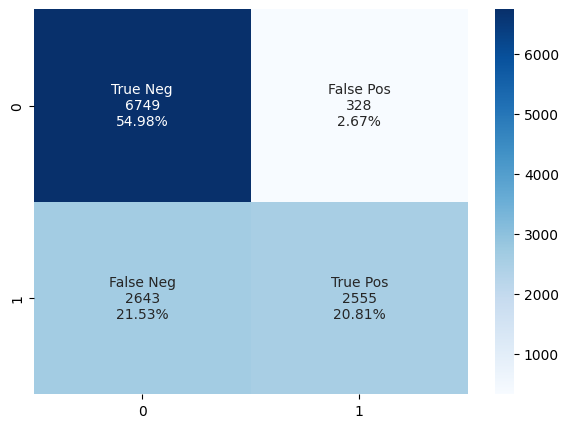

In [26]:
cm = confusion_matrix(y_test, predicted)
confusion_matrix_visualization(cm)


In [27]:
eval_report(y_test, predicted)

Accuracy score:0.7580
Balanced accuracy score:0.7226
F-1 score:0.6323
ROC-AUC score:0.7226


In [20]:
import pickle
with open('/content/gdrive/My Drive/embedding/tf_idf_3500.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

**Catboost**  

Very resource-intensive, requires GPU.

In [ ]:
model_cat = CatBoostClassifier()
model_cat.fit(X_train_tfidf, y_train)
predictions_cat = model_cat.predict(X_test_tfidf)
print(metrics.classification_report(y_test, predictions_cat))
print('F1: ', metrics.f1_score(y_test, predictions_cat))
print('ROC_AUC: ', metrics.roc_auc_score(y_test, predictions_cat))
print(metrics.confusion_matrix(y_test, predictions_cat))

Learning rate set to 0.054327
0:	learn: 0.6754015	total: 866ms	remaining: 14m 25s
1:	learn: 0.6598201	total: 1.94s	remaining: 16m 7s
2:	learn: 0.6478855	total: 2.95s	remaining: 16m 21s
3:	learn: 0.6362503	total: 3.75s	remaining: 15m 35s
4:	learn: 0.6261068	total: 4.48s	remaining: 14m 51s
5:	learn: 0.6171357	total: 5.03s	remaining: 13m 53s
6:	learn: 0.6101763	total: 5.57s	remaining: 13m 9s
7:	learn: 0.6033938	total: 6.12s	remaining: 12m 38s
8:	learn: 0.5968936	total: 6.67s	remaining: 12m 14s
9:	learn: 0.5918005	total: 7.21s	remaining: 11m 54s
10:	learn: 0.5864139	total: 7.78s	remaining: 11m 39s
11:	learn: 0.5828653	total: 8.31s	remaining: 11m 24s
12:	learn: 0.5777300	total: 8.87s	remaining: 11m 13s
13:	learn: 0.5743156	total: 9.42s	remaining: 11m 3s
14:	learn: 0.5712129	total: 9.98s	remaining: 10m 55s
15:	learn: 0.5678269	total: 10.7s	remaining: 10m 55s
16:	learn: 0.5655937	total: 11.6s	remaining: 11m 11s
17:	learn: 0.5630142	total: 12.6s	remaining: 11m 25s
18:	learn: 0.5610190	total: 1

KeyboardInterrupt: 

In [ ]:
model_cat.save_model('/content/gdrive/My Drive/models_fake_news/catboost_model.bin')

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 700, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('max_depth', 4, 8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2, 5),
       # 'bagging_temperature': trial.suggest_float("bagging_temperature", 0, 20),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', [None,'Balanced']),
        #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
        #'subsample': trial.suggest_float('subsample', 0.01, 0.1),
       #'task_type': 'GPU',
       'boosting_type': 'Ordered'
      # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
    }
    model = CatBoostClassifier(**params, silent=True)

    #model.fit(X_train_tfidf, y_train)
    #predictions = model.predict(X_test_tfidf)
    #f1 = metrics.f1_score(y_test, predictions)
    scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='f1')
    #roc_auc = roc_auc_score(y_test, predictions_xgb)
    return np.mean(scores)
    return f1

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-02-28 01:24:50,445] A new study created in memory with name: no-name-f7e2b11e-365d-4279-9564-12eeb81461c6


In [ ]:
# Get the best hyperparameters and best F1 score
best_params = study.best_params
best_score = study.best_value

In [ ]:
best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train_tfidf, y_train)
predictions_cat = best_model.predict(X_test_tfidf)
print(metrics.classification_report(y_test, predictions_cat))
print('F1: ', metrics.f1_score(y_test, predictions_cat))
print('ROC_AUC: ', metrics.roc_auc_score(y_test, predictions_cat))
print(metrics.confusion_matrix(y_test, predictions_cat))

In [ ]:
model_cat.save_model('/content/gdrive/My Drive/models_fake_news/catboost_model_best.bin')

**XGBoost**

In [28]:
positive_samples = np.sum(y_train == 1)
negative_samples = np.sum(y_train == 0)
imbalance_ratio = negative_samples / positive_samples

Accuracy score:0.7895
Balanced accuracy score:0.7650
F-1 score:0.7087
ROC-AUC score:0.7650


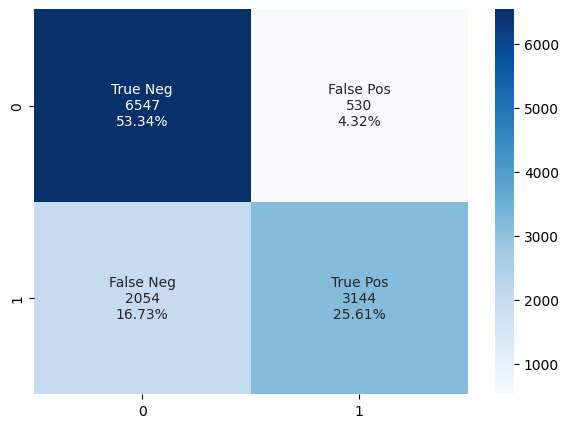

In [29]:
model_xgb = xgb.XGBClassifier(scale_pos_weight=imbalance_ratio)
model_xgb.fit(X_train_tfidf, y_train)
predictions_xgb = model_xgb.predict(X_test_tfidf)
eval_report(y_test, predictions_xgb)
cm = confusion_matrix(y_test, predictions_xgb)
confusion_matrix_visualization(cm)

In [30]:
model_xgb.save_model('/content/gdrive/My Drive/models_fake_news/xgboost_model.json')

**XGBoost + OPTUNA**

In [31]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 170),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 1.5),
        'eval_metric': 'aucpr'
    }

    model = xgb.XGBClassifier(**params)
    #model.fit(X_train_tfidf, y_train)
    #predictions_xgb = model.predict(X_test_tfidf)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_val_score(model, X_train_tfidf, y_train, cv=skf, scoring='roc_auc')
    #roc_auc = roc_auc_score(y_test, predictions_xgb)
    return np.mean(scores)

In [32]:
# Create Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

# Get the best hyperparameters and best F1 score
best_params = study.best_params
best_score = study.best_value

[I 2024-03-31 00:00:48,280] A new study created in memory with name: no-name-47f82504-f3f2-411e-acb0-46866ad6d212
[I 2024-03-31 00:01:16,088] Trial 0 finished with value: 0.6528176846033512 and parameters: {'max_depth': 8, 'learning_rate': 0.1642879431555242, 'n_estimators': 133, 'min_child_weight': 15, 'gamma': 2.263878282847891e-06, 'subsample': 0.018626530668443927, 'colsample_bytree': 0.6414282877689742, 'alpha': 0.033355065434607666, 'lambda': 0.2592605569079477, 'scale_pos_weight': 1.4690976496651253}. Best is trial 0 with value: 0.6528176846033512.
[I 2024-03-31 00:01:49,532] Trial 1 finished with value: 0.7574110131013683 and parameters: {'max_depth': 8, 'learning_rate': 0.3024398547571826, 'n_estimators': 115, 'min_child_weight': 10, 'gamma': 0.00423891040517043, 'subsample': 0.08692694589200822, 'colsample_bytree': 0.10659658800109034, 'alpha': 0.285826292712869, 'lambda': 0.6679386997318936, 'scale_pos_weight': 1.2217118971401546}. Best is trial 1 with value: 0.7574110131013

In [33]:
print(best_params)
print(best_score)

{'max_depth': 4, 'learning_rate': 0.29590912738331954, 'n_estimators': 137, 'min_child_weight': 10, 'gamma': 3.877924824268651e-06, 'subsample': 0.7321811649758878, 'colsample_bytree': 0.6775671894875651, 'alpha': 0.06700696661440605, 'lambda': 0.07700543018836516, 'scale_pos_weight': 1.4600592103189587}
0.8379430390269655


In [34]:
print(best_params)
print(best_score)

{'max_depth': 4, 'learning_rate': 0.29590912738331954, 'n_estimators': 137, 'min_child_weight': 10, 'gamma': 3.877924824268651e-06, 'subsample': 0.7321811649758878, 'colsample_bytree': 0.6775671894875651, 'alpha': 0.06700696661440605, 'lambda': 0.07700543018836516, 'scale_pos_weight': 1.4600592103189587}
0.8379430390269655


In [35]:
best_model = xgb.XGBClassifier(**best_params)

Accuracy score:0.7766
Balanced accuracy score:0.7569
F-1 score:0.7043
ROC-AUC score:0.7569


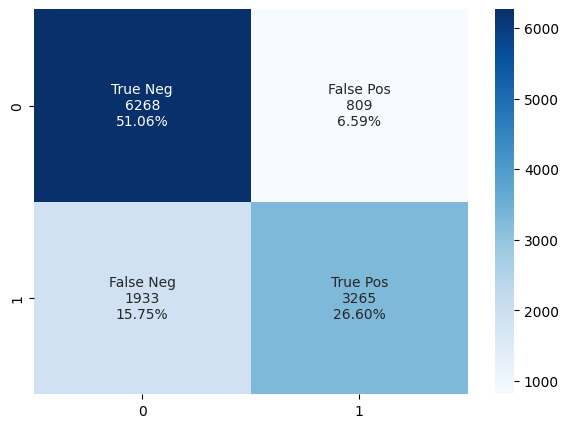

In [36]:
best_model.fit(X_train_tfidf, y_train)
predictions_best = best_model.predict(X_test_tfidf)
predictions_best_proba_train = best_model.predict_proba(X_train_tfidf)[:, 1]
predictions_best_proba_test = best_model.predict_proba(X_test_tfidf)[:, 1]

eval_report(y_test, predictions_best)
cm = confusion_matrix(y_test, predictions_best)
confusion_matrix_visualization(cm)

In [37]:
best_model.save_model('/content/gdrive/My Drive/models_fake_news/xgboost_best_model_cv_tfidf.json')

In [38]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [39]:
### return threshold where F1-score is the biggest
def best_tresholds_f1(y_pred_proba, y_test):
    # define thresholds
    thresholds = np.arange(0, 1, 0.001)
    # evaluate each threshold
    scores = [metrics.f1_score(y_test, to_labels(y_pred_proba, t)) for t in thresholds]
    # get best threshold
    ix = np.argmax(scores)
    #print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
    return thresholds[ix], scores[ix]

In [40]:
treshold_f1 = best_tresholds_f1(predictions_best_proba_train, y_train)
print(f'F1 score: {treshold_f1[1]:.4f}, treshold: {treshold_f1[0]}')

F1 score: 0.7358, treshold: 0.447


In [41]:
y_pred_463 = to_labels(predictions_best_proba_test, 0.37) #threshold = 0.463
metrics.f1_score(y_test, y_pred_463)

0.6846636509557859

LightGBM

In [42]:
import lightgbm as lgb
import joblib

[LightGBM] [Info] Number of positive: 20707, number of negative: 28390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.693051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 266930
[LightGBM] [Info] Number of data points in the train set: 49097, number of used features: 3489
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.421757 -> initscore=-0.315565
[LightGBM] [Info] Start training from score -0.315565
Accuracy score:0.7968
Balanced accuracy score:0.7663
F-1 score:0.7027
ROC-AUC score:0.7663


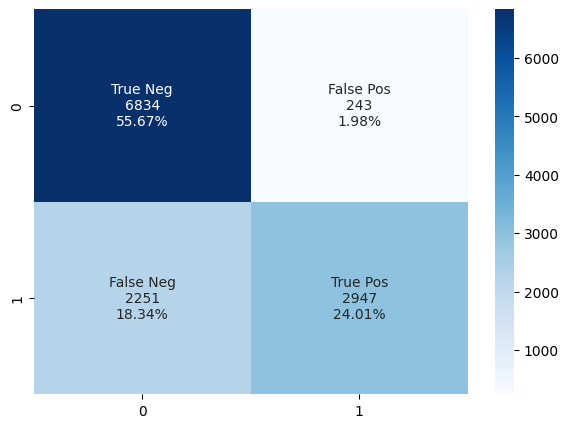

In [43]:
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train_tfidf, y_train)
predictions_lgb = model_lgb.predict(X_test_tfidf)

eval_report(y_test, predictions_lgb)
cm = confusion_matrix(y_test, predictions_lgb)
confusion_matrix_visualization(cm)

In [44]:
joblib.dump(model_lgb, '/content/gdrive/My Drive/models_fake_news/model_lgb.pkl')

['/content/gdrive/My Drive/models_fake_news/model_lgb.pkl']

In [45]:
model_lgb.booster_.save_model('/content/gdrive/My Drive/models_fake_news/model_lgb.txt')

LightGBM + OPTUNA

In [46]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'average_precision',
        'boosting_type': 'gbdt',
		    'num_iteration': trial.suggest_int('num_leaves', 70, 150),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        'min_data_in_leaf': trial.suggest_int('min_child_samples', 1, 100),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
    }

    model = lgb.LGBMClassifier(**params)
    #model.fit(X_train_tfidf, y_train)
    #predictions_xgb = model.predict(X_test_tfidf)'
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_val_score(model, X_train_tfidf, y_train, cv=skf, scoring='roc_auc')
    #roc_auc = roc_auc_score(y_test, predictions_xgb)
    return np.mean(scores)

In [47]:

# Create Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Get the best hyperparameters and best F1 score
best_params = study.best_params
best_score = study.best_value

[I 2024-03-31 00:25:40,220] A new study created in memory with name: no-name-b11e5eae-cba5-4121-a7c4-4c0f166bfb85
<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a

[LightGBM] [Warning] feature_fraction is set=0.9950022404016701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9950022404016701
[LightGBM] [Warning] lambda_l2 is set=1.348035985208907e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.348035985208907e-07
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] lambda_l1 is set=0.31821501765176674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31821501765176674
[LightGBM] [Warning] num_iterations is set=86, num_iteration=86 will be ignored. Current value: num_iterations=86
[LightGBM] [Warning] bagging_fraction is set=0.6343385417461256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6343385417461256
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ig

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] feature_fraction is set=0.9950022404016701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9950022404016701
[LightGBM] [Warning] lambda_l2 is set=1.348035985208907e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.348035985208907e-07
[LightGBM] [Warning] lambda_l1 is set=0.31821501765176674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31821501765176674
[LightGBM] [Warning] bagging_fraction is set=0.6343385417461256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6343385417461256
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 16565, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.660889 seconds.
You can set `force_

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] feature_fraction is set=0.9950022404016701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9950022404016701
[LightGBM] [Warning] lambda_l2 is set=1.348035985208907e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.348035985208907e-07
[LightGBM] [Warning] lambda_l1 is set=0.31821501765176674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31821501765176674
[LightGBM] [Warning] bagging_fraction is set=0.6343385417461256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6343385417461256
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.708029 seconds.
You can set `force_

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] feature_fraction is set=0.9950022404016701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9950022404016701
[LightGBM] [Warning] lambda_l2 is set=1.348035985208907e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.348035985208907e-07
[LightGBM] [Warning] lambda_l1 is set=0.31821501765176674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31821501765176674
[LightGBM] [Warning] bagging_fraction is set=0.6343385417461256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6343385417461256
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.125875 seconds.
You can set `force_

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] feature_fraction is set=0.9950022404016701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9950022404016701
[LightGBM] [Warning] lambda_l2 is set=1.348035985208907e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.348035985208907e-07
[LightGBM] [Warning] lambda_l1 is set=0.31821501765176674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31821501765176674
[LightGBM] [Warning] bagging_fraction is set=0.6343385417461256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6343385417461256
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.614151 seconds.
You can set `force_

[I 2024-03-31 00:28:06,139] Trial 0 finished with value: 0.8218578522252493 and parameters: {'num_leaves': 86, 'lambda_l1': 0.31821501765176674, 'lambda_l2': 1.348035985208907e-07, 'feature_fraction': 0.9950022404016701, 'bagging_fraction': 0.6343385417461256, 'bagging_freq': 3, 'min_child_samples': 54, 'class_weight': None}. Best is trial 0 with value: 0.8218578522252493.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] feature_fraction is set=0.9950022404016701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9950022404016701
[LightGBM] [Warning] lambda_l2 is set=1.348035985208907e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.348035985208907e-07
[LightGBM] [Warning] lambda_l1 is set=0.31821501765176674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31821501765176674
[LightGBM] [Warning] bagging_fraction is set=0.6343385417461256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6343385417461256
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8025661172613511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8025661172613511
[LightGBM] [Warning] lambda_l2 is set=1.

<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all f

[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.8025661172613511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8025661172613511
[LightGBM] [Warning] lambda_l2 is set=1.4239983352561993e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4239983352561993e-06
[LightGBM] [Warning] lambda_l1 is set=3.097676742716628e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.097676742716628e-05
[LightGBM] [Warning] bagging_fraction is set=0.3493115591656881, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3493115591656881
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 16565, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.058606 seconds.
You can set `

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8025661172613511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8025661172613511
[LightGBM] [Warning] lambda_l2 is set=1.4239983352561993e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4239983352561993e-06
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] lambda_l1 is set=3.097676742716628e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.097676742716628e-05
[LightGBM] [Warning] num_iterations is set=118, num_iteration=118 will be ignored. Current value: num_iterations=118
[LightGBM] [Warning] bagging_fraction is set=0.3493115591656881, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3493115591656881
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 w

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8025661172613511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8025661172613511
[LightGBM] [Warning] lambda_l2 is set=1.4239983352561993e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4239983352561993e-06
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] lambda_l1 is set=3.097676742716628e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.097676742716628e-05
[LightGBM] [Warning] num_iterations is set=118, num_iteration=118 will be ignored. Current value: num_iterations=118
[LightGBM] [Warning] bagging_fraction is set=0.3493115591656881, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3493115591656881
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 w

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8025661172613511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8025661172613511
[LightGBM] [Warning] lambda_l2 is set=1.4239983352561993e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4239983352561993e-06
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] lambda_l1 is set=3.097676742716628e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.097676742716628e-05
[LightGBM] [Warning] num_iterations is set=118, num_iteration=118 will be ignored. Current value: num_iterations=118
[LightGBM] [Warning] bagging_fraction is set=0.3493115591656881, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3493115591656881
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 w

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8025661172613511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8025661172613511
[LightGBM] [Warning] lambda_l2 is set=1.4239983352561993e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4239983352561993e-06
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] lambda_l1 is set=3.097676742716628e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.097676742716628e-05
[LightGBM] [Warning] num_iterations is set=118, num_iteration=118 will be ignored. Current value: num_iterations=118
[LightGBM] [Warning] bagging_fraction is set=0.3493115591656881, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3493115591656881
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 w

[I 2024-03-31 00:32:11,680] Trial 1 finished with value: 0.7995618390390119 and parameters: {'num_leaves': 118, 'lambda_l1': 3.097676742716628e-05, 'lambda_l2': 1.4239983352561993e-06, 'feature_fraction': 0.8025661172613511, 'bagging_fraction': 0.3493115591656881, 'bagging_freq': 1, 'min_child_samples': 28, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8218578522252493.
<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr

[LightGBM] [Warning] feature_fraction is set=0.14008530583585546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14008530583585546
[LightGBM] [Warning] lambda_l2 is set=0.03930375772437914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03930375772437914
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=5.635294178740637e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.635294178740637e-08
[LightGBM] [Warning] num_iterations is set=131, num_iteration=131 will be ignored. Current value: num_iterations=131
[LightGBM] [Warning] bagging_fraction is set=0.19576251287698293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19576251287698293
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 wil

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.14008530583585546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14008530583585546
[LightGBM] [Warning] lambda_l2 is set=0.03930375772437914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03930375772437914
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=5.635294178740637e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.635294178740637e-08
[LightGBM] [Warning] num_iterations is set=131, num_iteration=131 will be ignored. Current value: num_iterations=131
[LightGBM] [Warning] bagging_fraction is set=0.19576251287698293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19576251287698293
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 wil

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.14008530583585546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14008530583585546
[LightGBM] [Warning] lambda_l2 is set=0.03930375772437914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03930375772437914
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=5.635294178740637e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.635294178740637e-08
[LightGBM] [Warning] num_iterations is set=131, num_iteration=131 will be ignored. Current value: num_iterations=131
[LightGBM] [Warning] bagging_fraction is set=0.19576251287698293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19576251287698293
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 wil

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.14008530583585546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14008530583585546
[LightGBM] [Warning] lambda_l2 is set=0.03930375772437914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03930375772437914
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=5.635294178740637e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.635294178740637e-08
[LightGBM] [Warning] num_iterations is set=131, num_iteration=131 will be ignored. Current value: num_iterations=131
[LightGBM] [Warning] bagging_fraction is set=0.19576251287698293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19576251287698293
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 wil

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.14008530583585546, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14008530583585546
[LightGBM] [Warning] lambda_l2 is set=0.03930375772437914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03930375772437914
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] lambda_l1 is set=5.635294178740637e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.635294178740637e-08
[LightGBM] [Warning] num_iterations is set=131, num_iteration=131 will be ignored. Current value: num_iterations=131
[LightGBM] [Warning] bagging_fraction is set=0.19576251287698293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.19576251287698293
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=20 wil

[I 2024-03-31 00:33:00,493] Trial 2 finished with value: 0.7804951609353978 and parameters: {'num_leaves': 131, 'lambda_l1': 5.635294178740637e-08, 'lambda_l2': 0.03930375772437914, 'feature_fraction': 0.14008530583585546, 'bagging_fraction': 0.19576251287698293, 'bagging_freq': 8, 'min_child_samples': 38, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8218578522252493.
<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/

[LightGBM] [Warning] feature_fraction is set=0.8881230462440608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8881230462440608
[LightGBM] [Warning] lambda_l2 is set=0.002075241544571056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002075241544571056
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] lambda_l1 is set=0.011586740538540625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011586740538540625
[LightGBM] [Warning] num_iterations is set=126, num_iteration=126 will be ignored. Current value: num_iterations=126
[LightGBM] [Warning] bagging_fraction is set=0.8849617108179018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8849617108179018
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8881230462440608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8881230462440608
[LightGBM] [Warning] lambda_l2 is set=0.002075241544571056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002075241544571056
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] lambda_l1 is set=0.011586740538540625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011586740538540625
[LightGBM] [Warning] num_iterations is set=126, num_iteration=126 will be ignored. Current value: num_iterations=126
[LightGBM] [Warning] bagging_fraction is set=0.8849617108179018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8849617108179018
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8881230462440608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8881230462440608
[LightGBM] [Warning] lambda_l2 is set=0.002075241544571056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002075241544571056
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] lambda_l1 is set=0.011586740538540625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011586740538540625
[LightGBM] [Warning] num_iterations is set=126, num_iteration=126 will be ignored. Current value: num_iterations=126
[LightGBM] [Warning] bagging_fraction is set=0.8849617108179018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8849617108179018
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8881230462440608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8881230462440608
[LightGBM] [Warning] lambda_l2 is set=0.002075241544571056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002075241544571056
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] lambda_l1 is set=0.011586740538540625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011586740538540625
[LightGBM] [Warning] num_iterations is set=126, num_iteration=126 will be ignored. Current value: num_iterations=126
[LightGBM] [Warning] bagging_fraction is set=0.8849617108179018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8849617108179018
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8881230462440608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8881230462440608
[LightGBM] [Warning] lambda_l2 is set=0.002075241544571056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002075241544571056
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=62
[LightGBM] [Warning] lambda_l1 is set=0.011586740538540625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011586740538540625
[LightGBM] [Warning] num_iterations is set=126, num_iteration=126 will be ignored. Current value: num_iterations=126
[LightGBM] [Warning] bagging_fraction is set=0.8849617108179018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8849617108179018
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=62, min_child_samples=20 will be

[I 2024-03-31 00:37:11,908] Trial 3 finished with value: 0.8095068436195041 and parameters: {'num_leaves': 126, 'lambda_l1': 0.011586740538540625, 'lambda_l2': 0.002075241544571056, 'feature_fraction': 0.8881230462440608, 'bagging_fraction': 0.8849617108179018, 'bagging_freq': 6, 'min_child_samples': 62, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8218578522252493.
<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/lo

[LightGBM] [Warning] feature_fraction is set=0.9815153558235846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9815153558235846
[LightGBM] [Warning] lambda_l2 is set=5.0813369026330514e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0813369026330514e-06
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] lambda_l1 is set=1.787654837010974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.787654837010974
[LightGBM] [Warning] num_iterations is set=113, num_iteration=113 will be ignored. Current value: num_iterations=113
[LightGBM] [Warning] bagging_fraction is set=0.1543406516103184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1543406516103184
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be i

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9815153558235846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9815153558235846
[LightGBM] [Warning] lambda_l2 is set=5.0813369026330514e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0813369026330514e-06
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] lambda_l1 is set=1.787654837010974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.787654837010974
[LightGBM] [Warning] num_iterations is set=113, num_iteration=113 will be ignored. Current value: num_iterations=113
[LightGBM] [Warning] bagging_fraction is set=0.1543406516103184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1543406516103184
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be i

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9815153558235846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9815153558235846
[LightGBM] [Warning] lambda_l2 is set=5.0813369026330514e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0813369026330514e-06
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] lambda_l1 is set=1.787654837010974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.787654837010974
[LightGBM] [Warning] num_iterations is set=113, num_iteration=113 will be ignored. Current value: num_iterations=113
[LightGBM] [Warning] bagging_fraction is set=0.1543406516103184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1543406516103184
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be i

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9815153558235846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9815153558235846
[LightGBM] [Warning] lambda_l2 is set=5.0813369026330514e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0813369026330514e-06
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] lambda_l1 is set=1.787654837010974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.787654837010974
[LightGBM] [Warning] num_iterations is set=113, num_iteration=113 will be ignored. Current value: num_iterations=113
[LightGBM] [Warning] bagging_fraction is set=0.1543406516103184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1543406516103184
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be i

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9815153558235846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9815153558235846
[LightGBM] [Warning] lambda_l2 is set=5.0813369026330514e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0813369026330514e-06
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=37
[LightGBM] [Warning] lambda_l1 is set=1.787654837010974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.787654837010974
[LightGBM] [Warning] num_iterations is set=113, num_iteration=113 will be ignored. Current value: num_iterations=113
[LightGBM] [Warning] bagging_fraction is set=0.1543406516103184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1543406516103184
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=37, min_child_samples=20 will be i

[I 2024-03-31 00:38:26,970] Trial 4 finished with value: 0.786718842478862 and parameters: {'num_leaves': 113, 'lambda_l1': 1.787654837010974, 'lambda_l2': 5.0813369026330514e-06, 'feature_fraction': 0.9815153558235846, 'bagging_fraction': 0.1543406516103184, 'bagging_freq': 6, 'min_child_samples': 37, 'class_weight': None}. Best is trial 0 with value: 0.8218578522252493.
<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/local/lib/

[LightGBM] [Warning] feature_fraction is set=0.7242426055759799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7242426055759799
[LightGBM] [Warning] lambda_l2 is set=3.1410151354471125e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1410151354471125e-08
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] lambda_l1 is set=2.326254436110919e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.326254436110919e-05
[LightGBM] [Warning] num_iterations is set=140, num_iteration=140 will be ignored. Current value: num_iterations=140
[LightGBM] [Warning] bagging_fraction is set=0.6466684467227406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6466684467227406
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7242426055759799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7242426055759799
[LightGBM] [Warning] lambda_l2 is set=3.1410151354471125e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1410151354471125e-08
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] lambda_l1 is set=2.326254436110919e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.326254436110919e-05
[LightGBM] [Warning] num_iterations is set=140, num_iteration=140 will be ignored. Current value: num_iterations=140
[LightGBM] [Warning] bagging_fraction is set=0.6466684467227406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6466684467227406
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7242426055759799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7242426055759799
[LightGBM] [Warning] lambda_l2 is set=3.1410151354471125e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1410151354471125e-08
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] lambda_l1 is set=2.326254436110919e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.326254436110919e-05
[LightGBM] [Warning] num_iterations is set=140, num_iteration=140 will be ignored. Current value: num_iterations=140
[LightGBM] [Warning] bagging_fraction is set=0.6466684467227406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6466684467227406
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7242426055759799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7242426055759799
[LightGBM] [Warning] lambda_l2 is set=3.1410151354471125e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1410151354471125e-08
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] lambda_l1 is set=2.326254436110919e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.326254436110919e-05
[LightGBM] [Warning] num_iterations is set=140, num_iteration=140 will be ignored. Current value: num_iterations=140
[LightGBM] [Warning] bagging_fraction is set=0.6466684467227406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6466684467227406
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7242426055759799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7242426055759799
[LightGBM] [Warning] lambda_l2 is set=3.1410151354471125e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1410151354471125e-08
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] lambda_l1 is set=2.326254436110919e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.326254436110919e-05
[LightGBM] [Warning] num_iterations is set=140, num_iteration=140 will be ignored. Current value: num_iterations=140
[LightGBM] [Warning] bagging_fraction is set=0.6466684467227406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6466684467227406
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20

[I 2024-03-31 00:41:43,147] Trial 5 finished with value: 0.7886802675396679 and parameters: {'num_leaves': 140, 'lambda_l1': 2.326254436110919e-05, 'lambda_l2': 3.1410151354471125e-08, 'feature_fraction': 0.7242426055759799, 'bagging_fraction': 0.6466684467227406, 'bagging_freq': 10, 'min_child_samples': 74, 'class_weight': None}. Best is trial 0 with value: 0.8218578522252493.
<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/loca

[LightGBM] [Warning] feature_fraction is set=0.8290677011899559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8290677011899559
[LightGBM] [Warning] lambda_l2 is set=1.1107276345934285e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1107276345934285e-05
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] lambda_l1 is set=3.511101637891432e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.511101637891432e-08
[LightGBM] [Warning] num_iterations is set=129, num_iteration=129 will be ignored. Current value: num_iterations=129
[LightGBM] [Warning] bagging_fraction is set=0.48555274227181977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48555274227181977
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8290677011899559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8290677011899559
[LightGBM] [Warning] lambda_l2 is set=1.1107276345934285e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1107276345934285e-05
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] lambda_l1 is set=3.511101637891432e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.511101637891432e-08
[LightGBM] [Warning] num_iterations is set=129, num_iteration=129 will be ignored. Current value: num_iterations=129
[LightGBM] [Warning] bagging_fraction is set=0.48555274227181977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48555274227181977
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8290677011899559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8290677011899559
[LightGBM] [Warning] lambda_l2 is set=1.1107276345934285e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1107276345934285e-05
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] lambda_l1 is set=3.511101637891432e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.511101637891432e-08
[LightGBM] [Warning] num_iterations is set=129, num_iteration=129 will be ignored. Current value: num_iterations=129
[LightGBM] [Warning] bagging_fraction is set=0.48555274227181977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48555274227181977
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8290677011899559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8290677011899559
[LightGBM] [Warning] lambda_l2 is set=1.1107276345934285e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1107276345934285e-05
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] lambda_l1 is set=3.511101637891432e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.511101637891432e-08
[LightGBM] [Warning] num_iterations is set=129, num_iteration=129 will be ignored. Current value: num_iterations=129
[LightGBM] [Warning] bagging_fraction is set=0.48555274227181977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48555274227181977
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8290677011899559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8290677011899559
[LightGBM] [Warning] lambda_l2 is set=1.1107276345934285e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1107276345934285e-05
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=33
[LightGBM] [Warning] lambda_l1 is set=3.511101637891432e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.511101637891432e-08
[LightGBM] [Warning] num_iterations is set=129, num_iteration=129 will be ignored. Current value: num_iterations=129
[LightGBM] [Warning] bagging_fraction is set=0.48555274227181977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48555274227181977
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] min_data_in_leaf is set=33, min_child_samples=20

[I 2024-03-31 00:45:54,280] Trial 6 finished with value: 0.802129727843988 and parameters: {'num_leaves': 129, 'lambda_l1': 3.511101637891432e-08, 'lambda_l2': 1.1107276345934285e-05, 'feature_fraction': 0.8290677011899559, 'bagging_fraction': 0.48555274227181977, 'bagging_freq': 9, 'min_child_samples': 33, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8218578522252493.
<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr

[LightGBM] [Warning] feature_fraction is set=0.8806434946338872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8806434946338872
[LightGBM] [Warning] lambda_l2 is set=3.4083660709309013e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4083660709309013e-06
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] lambda_l1 is set=5.6732821668270596e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6732821668270596e-08
[LightGBM] [Warning] num_iterations is set=125, num_iteration=125 will be ignored. Current value: num_iterations=125
[LightGBM] [Warning] bagging_fraction is set=0.5419164081587379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5419164081587379
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8806434946338872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8806434946338872
[LightGBM] [Warning] lambda_l2 is set=3.4083660709309013e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4083660709309013e-06
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] lambda_l1 is set=5.6732821668270596e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6732821668270596e-08
[LightGBM] [Warning] num_iterations is set=125, num_iteration=125 will be ignored. Current value: num_iterations=125
[LightGBM] [Warning] bagging_fraction is set=0.5419164081587379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5419164081587379
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8806434946338872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8806434946338872
[LightGBM] [Warning] lambda_l2 is set=3.4083660709309013e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4083660709309013e-06
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] lambda_l1 is set=5.6732821668270596e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6732821668270596e-08
[LightGBM] [Warning] num_iterations is set=125, num_iteration=125 will be ignored. Current value: num_iterations=125
[LightGBM] [Warning] bagging_fraction is set=0.5419164081587379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5419164081587379
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8806434946338872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8806434946338872
[LightGBM] [Warning] lambda_l2 is set=3.4083660709309013e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4083660709309013e-06
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] lambda_l1 is set=5.6732821668270596e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6732821668270596e-08
[LightGBM] [Warning] num_iterations is set=125, num_iteration=125 will be ignored. Current value: num_iterations=125
[LightGBM] [Warning] bagging_fraction is set=0.5419164081587379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5419164081587379
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8806434946338872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8806434946338872
[LightGBM] [Warning] lambda_l2 is set=3.4083660709309013e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4083660709309013e-06
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] lambda_l1 is set=5.6732821668270596e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6732821668270596e-08
[LightGBM] [Warning] num_iterations is set=125, num_iteration=125 will be ignored. Current value: num_iterations=125
[LightGBM] [Warning] bagging_fraction is set=0.5419164081587379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5419164081587379
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20

[I 2024-03-31 00:49:07,167] Trial 7 finished with value: 0.7939168573323253 and parameters: {'num_leaves': 125, 'lambda_l1': 5.6732821668270596e-08, 'lambda_l2': 3.4083660709309013e-06, 'feature_fraction': 0.8806434946338872, 'bagging_fraction': 0.5419164081587379, 'bagging_freq': 8, 'min_child_samples': 60, 'class_weight': None}. Best is trial 0 with value: 0.8218578522252493.
<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/loca

[LightGBM] [Warning] feature_fraction is set=0.8021405397715715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8021405397715715
[LightGBM] [Warning] lambda_l2 is set=0.04875498037597694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04875498037597694
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] lambda_l1 is set=7.116927440141963e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.116927440141963e-06
[LightGBM] [Warning] num_iterations is set=134, num_iteration=134 will be ignored. Current value: num_iterations=134
[LightGBM] [Warning] bagging_fraction is set=0.7723764507252652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7723764507252652
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8021405397715715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8021405397715715
[LightGBM] [Warning] lambda_l2 is set=0.04875498037597694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04875498037597694
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] lambda_l1 is set=7.116927440141963e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.116927440141963e-06
[LightGBM] [Warning] num_iterations is set=134, num_iteration=134 will be ignored. Current value: num_iterations=134
[LightGBM] [Warning] bagging_fraction is set=0.7723764507252652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7723764507252652
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8021405397715715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8021405397715715
[LightGBM] [Warning] lambda_l2 is set=0.04875498037597694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04875498037597694
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] lambda_l1 is set=7.116927440141963e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.116927440141963e-06
[LightGBM] [Warning] num_iterations is set=134, num_iteration=134 will be ignored. Current value: num_iterations=134
[LightGBM] [Warning] bagging_fraction is set=0.7723764507252652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7723764507252652
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8021405397715715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8021405397715715
[LightGBM] [Warning] lambda_l2 is set=0.04875498037597694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04875498037597694
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] lambda_l1 is set=7.116927440141963e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.116927440141963e-06
[LightGBM] [Warning] num_iterations is set=134, num_iteration=134 will be ignored. Current value: num_iterations=134
[LightGBM] [Warning] bagging_fraction is set=0.7723764507252652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7723764507252652
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8021405397715715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8021405397715715
[LightGBM] [Warning] lambda_l2 is set=0.04875498037597694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04875498037597694
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] lambda_l1 is set=7.116927440141963e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.116927440141963e-06
[LightGBM] [Warning] num_iterations is set=134, num_iteration=134 will be ignored. Current value: num_iterations=134
[LightGBM] [Warning] bagging_fraction is set=0.7723764507252652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7723764507252652
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be

[I 2024-03-31 00:53:15,161] Trial 8 finished with value: 0.800895696200333 and parameters: {'num_leaves': 134, 'lambda_l1': 7.116927440141963e-06, 'lambda_l2': 0.04875498037597694, 'feature_fraction': 0.8021405397715715, 'bagging_fraction': 0.7723764507252652, 'bagging_freq': 7, 'min_child_samples': 61, 'class_weight': None}. Best is trial 0 with value: 0.8218578522252493.
<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/local/lib

[LightGBM] [Warning] feature_fraction is set=0.554895297513024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.554895297513024
[LightGBM] [Warning] lambda_l2 is set=1.083650788856549e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.083650788856549e-08
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] lambda_l1 is set=0.3250133246098369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3250133246098369
[LightGBM] [Warning] num_iterations is set=79, num_iteration=79 will be ignored. Current value: num_iterations=79
[LightGBM] [Warning] bagging_fraction is set=0.6707843335969422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6707843335969422
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignore

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.554895297513024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.554895297513024
[LightGBM] [Warning] lambda_l2 is set=1.083650788856549e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.083650788856549e-08
[LightGBM] [Warning] lambda_l1 is set=0.3250133246098369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3250133246098369
[LightGBM] [Warning] bagging_fraction is set=0.6707843335969422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6707843335969422
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 16565, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.526780 seconds.
You can set `force_row_

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.554895297513024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.554895297513024
[LightGBM] [Warning] lambda_l2 is set=1.083650788856549e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.083650788856549e-08
[LightGBM] [Warning] lambda_l1 is set=0.3250133246098369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3250133246098369
[LightGBM] [Warning] bagging_fraction is set=0.6707843335969422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6707843335969422
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.561003 seconds.
You can set `force_row_

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.554895297513024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.554895297513024
[LightGBM] [Warning] lambda_l2 is set=1.083650788856549e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.083650788856549e-08
[LightGBM] [Warning] lambda_l1 is set=0.3250133246098369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3250133246098369
[LightGBM] [Warning] bagging_fraction is set=0.6707843335969422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6707843335969422
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.521022 seconds.
You can set `force_col_

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.554895297513024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.554895297513024
[LightGBM] [Warning] lambda_l2 is set=1.083650788856549e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.083650788856549e-08
[LightGBM] [Warning] lambda_l1 is set=0.3250133246098369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3250133246098369
[LightGBM] [Warning] bagging_fraction is set=0.6707843335969422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6707843335969422
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.515201 seconds.
You can set `force_col_

[I 2024-03-31 00:54:38,893] Trial 9 finished with value: 0.8224156711912685 and parameters: {'num_leaves': 79, 'lambda_l1': 0.3250133246098369, 'lambda_l2': 1.083650788856549e-08, 'feature_fraction': 0.554895297513024, 'bagging_fraction': 0.6707843335969422, 'bagging_freq': 7, 'min_child_samples': 68, 'class_weight': None}. Best is trial 9 with value: 0.8224156711912685.


[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.554895297513024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.554895297513024
[LightGBM] [Warning] lambda_l2 is set=1.083650788856549e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.083650788856549e-08
[LightGBM] [Warning] lambda_l1 is set=0.3250133246098369, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3250133246098369
[LightGBM] [Warning] bagging_fraction is set=0.6707843335969422, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6707843335969422
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4300324396095686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4300324396095686
[LightGBM] [Warning] lambda_l2 is set=0.0005

<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all f

[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.4300324396095686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4300324396095686
[LightGBM] [Warning] lambda_l2 is set=0.0005384409534462252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005384409534462252
[LightGBM] [Warning] lambda_l1 is set=0.007780269014614097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007780269014614097
[LightGBM] [Warning] bagging_fraction is set=0.9843993659784831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9843993659784831
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 16565, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.411086 seconds.
You can set `forc

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.4300324396095686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4300324396095686
[LightGBM] [Warning] lambda_l2 is set=0.0005384409534462252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005384409534462252
[LightGBM] [Warning] lambda_l1 is set=0.007780269014614097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007780269014614097
[LightGBM] [Warning] bagging_fraction is set=0.9843993659784831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9843993659784831
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 16565, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.412700 seconds.
You can set `forc

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.4300324396095686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4300324396095686
[LightGBM] [Warning] lambda_l2 is set=0.0005384409534462252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005384409534462252
[LightGBM] [Warning] lambda_l1 is set=0.007780269014614097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007780269014614097
[LightGBM] [Warning] bagging_fraction is set=0.9843993659784831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9843993659784831
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.422313 seconds.
You can set `forc

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.4300324396095686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4300324396095686
[LightGBM] [Warning] lambda_l2 is set=0.0005384409534462252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005384409534462252
[LightGBM] [Warning] lambda_l1 is set=0.007780269014614097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007780269014614097
[LightGBM] [Warning] bagging_fraction is set=0.9843993659784831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9843993659784831
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.388505 seconds.
You can set `forc

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.4300324396095686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4300324396095686
[LightGBM] [Warning] lambda_l2 is set=0.0005384409534462252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005384409534462252
[LightGBM] [Warning] lambda_l1 is set=0.007780269014614097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007780269014614097
[LightGBM] [Warning] bagging_fraction is set=0.9843993659784831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9843993659784831
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.413307 seconds.
You can set `forc

[I 2024-03-31 00:55:42,560] Trial 10 finished with value: 0.8283651941254406 and parameters: {'num_leaves': 70, 'lambda_l1': 0.007780269014614097, 'lambda_l2': 0.0005384409534462252, 'feature_fraction': 0.4300324396095686, 'bagging_fraction': 0.9843993659784831, 'bagging_freq': 4, 'min_child_samples': 99, 'class_weight': None}. Best is trial 10 with value: 0.8283651941254406.


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.4300324396095686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4300324396095686
[LightGBM] [Warning] lambda_l2 is set=0.0005384409534462252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005384409534462252
[LightGBM] [Warning] lambda_l1 is set=0.007780269014614097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007780269014614097
[LightGBM] [Warning] bagging_fraction is set=0.9843993659784831, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9843993659784831
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.35442874911685107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35442874911685107
[LightGBM] [Warning] lambda_l2 is se

<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all f

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.35442874911685107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35442874911685107
[LightGBM] [Warning] lambda_l2 is set=2.9961041040555307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9961041040555307
[LightGBM] [Warning] lambda_l1 is set=0.0090672937534877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0090672937534877
[LightGBM] [Warning] bagging_fraction is set=0.9994319236457065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994319236457065
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 16565, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.438441 seconds.
You can set `force_row_wi

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.35442874911685107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35442874911685107
[LightGBM] [Warning] lambda_l2 is set=2.9961041040555307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9961041040555307
[LightGBM] [Warning] lambda_l1 is set=0.0090672937534877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0090672937534877
[LightGBM] [Warning] bagging_fraction is set=0.9994319236457065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994319236457065
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 16565, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.416473 seconds.
You can set `force_row_wi

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.35442874911685107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35442874911685107
[LightGBM] [Warning] lambda_l2 is set=2.9961041040555307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9961041040555307
[LightGBM] [Warning] lambda_l1 is set=0.0090672937534877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0090672937534877
[LightGBM] [Warning] bagging_fraction is set=0.9994319236457065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994319236457065
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.414815 seconds.
You can set `force_row_wi

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.35442874911685107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35442874911685107
[LightGBM] [Warning] lambda_l2 is set=2.9961041040555307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9961041040555307
[LightGBM] [Warning] lambda_l1 is set=0.0090672937534877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0090672937534877
[LightGBM] [Warning] bagging_fraction is set=0.9994319236457065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994319236457065
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.472809 seconds.
You can set `force_col_wi

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.35442874911685107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35442874911685107
[LightGBM] [Warning] lambda_l2 is set=2.9961041040555307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9961041040555307
[LightGBM] [Warning] lambda_l1 is set=0.0090672937534877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0090672937534877
[LightGBM] [Warning] bagging_fraction is set=0.9994319236457065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994319236457065
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.772782 seconds.
You can set `force_col_wi

[I 2024-03-31 00:56:41,638] Trial 11 finished with value: 0.8300715644320492 and parameters: {'num_leaves': 70, 'lambda_l1': 0.0090672937534877, 'lambda_l2': 2.9961041040555307, 'feature_fraction': 0.35442874911685107, 'bagging_fraction': 0.9994319236457065, 'bagging_freq': 4, 'min_child_samples': 90, 'class_weight': None}. Best is trial 11 with value: 0.8300715644320492.


[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.35442874911685107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35442874911685107
[LightGBM] [Warning] lambda_l2 is set=2.9961041040555307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9961041040555307
[LightGBM] [Warning] lambda_l1 is set=0.0090672937534877, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0090672937534877
[LightGBM] [Warning] bagging_fraction is set=0.9994319236457065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994319236457065
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2964482908550868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2964482908550868
[LightGBM] [Warning] lambda_l2 is set=2.042419

<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all f

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.2964482908550868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2964482908550868
[LightGBM] [Warning] lambda_l2 is set=2.0424198271779863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0424198271779863
[LightGBM] [Warning] lambda_l1 is set=0.004141154420028898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004141154420028898
[LightGBM] [Warning] bagging_fraction is set=0.9281769807093476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9281769807093476
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 16565, number of negative: 22712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.478342 seconds.
You can set `force_co

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.2964482908550868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2964482908550868
[LightGBM] [Warning] lambda_l2 is set=2.0424198271779863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0424198271779863
[LightGBM] [Warning] lambda_l1 is set=0.004141154420028898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004141154420028898
[LightGBM] [Warning] bagging_fraction is set=0.9281769807093476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9281769807093476
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 16565, number of negative: 22712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.394066 seconds.
You can set `force_co

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.2964482908550868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2964482908550868
[LightGBM] [Warning] lambda_l2 is set=2.0424198271779863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0424198271779863
[LightGBM] [Warning] lambda_l1 is set=0.004141154420028898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004141154420028898
[LightGBM] [Warning] bagging_fraction is set=0.9281769807093476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9281769807093476
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.415417 seconds.
You can set `force_ro

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.2964482908550868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2964482908550868
[LightGBM] [Warning] lambda_l2 is set=2.0424198271779863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0424198271779863
[LightGBM] [Warning] lambda_l1 is set=0.004141154420028898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004141154420028898
[LightGBM] [Warning] bagging_fraction is set=0.9281769807093476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9281769807093476
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.410695 seconds.
You can set `force_ro

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.2964482908550868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2964482908550868
[LightGBM] [Warning] lambda_l2 is set=2.0424198271779863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0424198271779863
[LightGBM] [Warning] lambda_l1 is set=0.004141154420028898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004141154420028898
[LightGBM] [Warning] bagging_fraction is set=0.9281769807093476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9281769807093476
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.509933 seconds.
You can set `force_co

[I 2024-03-31 00:57:34,654] Trial 12 finished with value: 0.822340860057922 and parameters: {'num_leaves': 70, 'lambda_l1': 0.004141154420028898, 'lambda_l2': 2.0424198271779863, 'feature_fraction': 0.2964482908550868, 'bagging_fraction': 0.9281769807093476, 'bagging_freq': 3, 'min_child_samples': 100, 'class_weight': None}. Best is trial 11 with value: 0.8300715644320492.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.2964482908550868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2964482908550868
[LightGBM] [Warning] lambda_l2 is set=2.0424198271779863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0424198271779863
[LightGBM] [Warning] lambda_l1 is set=0.004141154420028898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004141154420028898
[LightGBM] [Warning] bagging_fraction is set=0.9281769807093476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9281769807093476
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.4082765767030636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4082765767030636
[LightGBM] [Warning] lambda_l2 is set=3.03

<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all f

[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.4082765767030636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4082765767030636
[LightGBM] [Warning] lambda_l2 is set=3.0370737204962084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0370737204962084
[LightGBM] [Warning] lambda_l1 is set=0.0029897933016757353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0029897933016757353
[LightGBM] [Warning] bagging_fraction is set=0.9808954337017248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9808954337017248
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 16565, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.388144 seconds.
You can set `force_ro

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4082765767030636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4082765767030636
[LightGBM] [Warning] lambda_l2 is set=3.0370737204962084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0370737204962084
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] lambda_l1 is set=0.0029897933016757353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0029897933016757353
[LightGBM] [Warning] num_iterations is set=94, num_iteration=94 will be ignored. Current value: num_iterations=94
[LightGBM] [Warning] bagging_fraction is set=0.9808954337017248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9808954337017248
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be igno

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.4082765767030636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4082765767030636
[LightGBM] [Warning] lambda_l2 is set=3.0370737204962084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0370737204962084
[LightGBM] [Warning] lambda_l1 is set=0.0029897933016757353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0029897933016757353
[LightGBM] [Warning] bagging_fraction is set=0.9808954337017248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9808954337017248
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.637214 seconds.
You can set `force_co

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.4082765767030636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4082765767030636
[LightGBM] [Warning] lambda_l2 is set=3.0370737204962084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0370737204962084
[LightGBM] [Warning] lambda_l1 is set=0.0029897933016757353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0029897933016757353
[LightGBM] [Warning] bagging_fraction is set=0.9808954337017248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9808954337017248
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.397472 seconds.
You can set `force_ro

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.4082765767030636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4082765767030636
[LightGBM] [Warning] lambda_l2 is set=3.0370737204962084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0370737204962084
[LightGBM] [Warning] lambda_l1 is set=0.0029897933016757353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0029897933016757353
[LightGBM] [Warning] bagging_fraction is set=0.9808954337017248, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9808954337017248
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.390922 seconds.
You can set `force_ro

[I 2024-03-31 00:59:11,947] Trial 13 finished with value: 0.8203964654494149 and parameters: {'num_leaves': 94, 'lambda_l1': 0.0029897933016757353, 'lambda_l2': 3.0370737204962084, 'feature_fraction': 0.4082765767030636, 'bagging_fraction': 0.9808954337017248, 'bagging_freq': 4, 'min_child_samples': 99, 'class_weight': None}. Best is trial 11 with value: 0.8300715644320492.
<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/local/li

[LightGBM] [Warning] feature_fraction is set=0.46589064636055044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46589064636055044
[LightGBM] [Warning] lambda_l2 is set=0.00040951897384737437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040951897384737437
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l1 is set=0.0005935002676470299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005935002676470299
[LightGBM] [Warning] num_iterations is set=101, num_iteration=101 will be ignored. Current value: num_iterations=101
[LightGBM] [Warning] bagging_fraction is set=0.8245929157155876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8245929157155876
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 wi

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.46589064636055044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46589064636055044
[LightGBM] [Warning] lambda_l2 is set=0.00040951897384737437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040951897384737437
[LightGBM] [Warning] lambda_l1 is set=0.0005935002676470299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005935002676470299
[LightGBM] [Warning] bagging_fraction is set=0.8245929157155876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8245929157155876
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 16565, number of negative: 22712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.950553 seconds.
You can set `

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.46589064636055044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46589064636055044
[LightGBM] [Warning] lambda_l2 is set=0.00040951897384737437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040951897384737437
[LightGBM] [Warning] lambda_l1 is set=0.0005935002676470299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005935002676470299
[LightGBM] [Warning] bagging_fraction is set=0.8245929157155876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8245929157155876
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.967220 seconds.
You can set `

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.46589064636055044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46589064636055044
[LightGBM] [Warning] lambda_l2 is set=0.00040951897384737437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040951897384737437
[LightGBM] [Warning] lambda_l1 is set=0.0005935002676470299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005935002676470299
[LightGBM] [Warning] bagging_fraction is set=0.8245929157155876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8245929157155876
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.374860 seconds.
You can set `

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.46589064636055044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46589064636055044
[LightGBM] [Warning] lambda_l2 is set=0.00040951897384737437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040951897384737437
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l1 is set=0.0005935002676470299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005935002676470299
[LightGBM] [Warning] num_iterations is set=101, num_iteration=101 will be ignored. Current value: num_iterations=101
[LightGBM] [Warning] bagging_fraction is set=0.8245929157155876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8245929157155876
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 wi

[I 2024-03-31 01:01:41,162] Trial 14 finished with value: 0.8382665127034429 and parameters: {'num_leaves': 101, 'lambda_l1': 0.0005935002676470299, 'lambda_l2': 0.00040951897384737437, 'feature_fraction': 0.46589064636055044, 'bagging_fraction': 0.8245929157155876, 'bagging_freq': 0, 'min_child_samples': 5, 'class_weight': None}. Best is trial 14 with value: 0.8382665127034429.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.46589064636055044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46589064636055044
[LightGBM] [Warning] lambda_l2 is set=0.00040951897384737437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040951897384737437
[LightGBM] [Warning] lambda_l1 is set=0.0005935002676470299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005935002676470299
[LightGBM] [Warning] bagging_fraction is set=0.8245929157155876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8245929157155876
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all f

[LightGBM] [Warning] feature_fraction is set=0.6059214861030116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6059214861030116
[LightGBM] [Warning] lambda_l2 is set=0.03823918021085263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03823918021085263
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] lambda_l1 is set=0.00023713179464305553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00023713179464305553
[LightGBM] [Warning] num_iterations is set=98, num_iteration=98 will be ignored. Current value: num_iterations=98
[LightGBM] [Warning] bagging_fraction is set=0.811383056854317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.811383056854317
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignor

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.6059214861030116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6059214861030116
[LightGBM] [Warning] lambda_l2 is set=0.03823918021085263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03823918021085263
[LightGBM] [Warning] lambda_l1 is set=0.00023713179464305553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00023713179464305553
[LightGBM] [Warning] bagging_fraction is set=0.811383056854317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.811383056854317
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 16565, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.983387 seconds.
You can set `force_ro

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.6059214861030116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6059214861030116
[LightGBM] [Warning] lambda_l2 is set=0.03823918021085263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03823918021085263
[LightGBM] [Warning] lambda_l1 is set=0.00023713179464305553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00023713179464305553
[LightGBM] [Warning] bagging_fraction is set=0.811383056854317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.811383056854317
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.999924 seconds.
You can set `force_ro

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.6059214861030116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6059214861030116
[LightGBM] [Warning] lambda_l2 is set=0.03823918021085263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03823918021085263
[LightGBM] [Warning] lambda_l1 is set=0.00023713179464305553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00023713179464305553
[LightGBM] [Warning] bagging_fraction is set=0.811383056854317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.811383056854317
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.940461 seconds.
You can set `force_ro

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.6059214861030116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6059214861030116
[LightGBM] [Warning] lambda_l2 is set=0.03823918021085263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03823918021085263
[LightGBM] [Warning] lambda_l1 is set=0.00023713179464305553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00023713179464305553
[LightGBM] [Warning] bagging_fraction is set=0.811383056854317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.811383056854317
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.958322 seconds.
You can set `force_ro

[I 2024-03-31 01:04:12,840] Trial 15 finished with value: 0.838421838163188 and parameters: {'num_leaves': 98, 'lambda_l1': 0.00023713179464305553, 'lambda_l2': 0.03823918021085263, 'feature_fraction': 0.6059214861030116, 'bagging_fraction': 0.811383056854317, 'bagging_freq': 0, 'min_child_samples': 4, 'class_weight': None}. Best is trial 15 with value: 0.838421838163188.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.6059214861030116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6059214861030116
[LightGBM] [Warning] lambda_l2 is set=0.03823918021085263, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03823918021085263
[LightGBM] [Warning] lambda_l1 is set=0.00023713179464305553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00023713179464305553
[LightGBM] [Warning] bagging_fraction is set=0.811383056854317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.811383056854317
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all f

[LightGBM] [Warning] feature_fraction is set=0.6042844684544197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6042844684544197
[LightGBM] [Warning] lambda_l2 is set=0.015446064705094659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015446064705094659
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=0.000303314864553927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000303314864553927
[LightGBM] [Warning] num_iterations is set=100, num_iteration=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] bagging_fraction is set=0.7662473806058628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662473806058628
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ig

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6042844684544197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6042844684544197
[LightGBM] [Warning] lambda_l2 is set=0.015446064705094659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015446064705094659
[LightGBM] [Warning] lambda_l1 is set=0.000303314864553927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000303314864553927
[LightGBM] [Warning] bagging_fraction is set=0.7662473806058628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662473806058628
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 16565, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.962001 seconds.
You can set `force_ro

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6042844684544197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6042844684544197
[LightGBM] [Warning] lambda_l2 is set=0.015446064705094659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015446064705094659
[LightGBM] [Warning] lambda_l1 is set=0.000303314864553927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000303314864553927
[LightGBM] [Warning] bagging_fraction is set=0.7662473806058628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662473806058628
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.419421 seconds.
You can set `force_ro

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6042844684544197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6042844684544197
[LightGBM] [Warning] lambda_l2 is set=0.015446064705094659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015446064705094659
[LightGBM] [Warning] lambda_l1 is set=0.000303314864553927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000303314864553927
[LightGBM] [Warning] bagging_fraction is set=0.7662473806058628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662473806058628
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.933422 seconds.
You can set `force_ro

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6042844684544197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6042844684544197
[LightGBM] [Warning] lambda_l2 is set=0.015446064705094659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015446064705094659
[LightGBM] [Warning] lambda_l1 is set=0.000303314864553927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000303314864553927
[LightGBM] [Warning] bagging_fraction is set=0.7662473806058628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662473806058628
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.953274 seconds.
You can set `force_ro

[I 2024-03-31 01:07:20,862] Trial 16 finished with value: 0.8372151065057839 and parameters: {'num_leaves': 100, 'lambda_l1': 0.000303314864553927, 'lambda_l2': 0.015446064705094659, 'feature_fraction': 0.6042844684544197, 'bagging_fraction': 0.7662473806058628, 'bagging_freq': 0, 'min_child_samples': 1, 'class_weight': None}. Best is trial 15 with value: 0.838421838163188.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6042844684544197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6042844684544197
[LightGBM] [Warning] lambda_l2 is set=0.015446064705094659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015446064705094659
[LightGBM] [Warning] lambda_l1 is set=0.000303314864553927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000303314864553927
[LightGBM] [Warning] bagging_fraction is set=0.7662473806058628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662473806058628
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all f

[LightGBM] [Warning] feature_fraction is set=0.6797365181489236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6797365181489236
[LightGBM] [Warning] lambda_l2 is set=8.473299603643343e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.473299603643343e-05
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l1 is set=1.6894640621933276e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6894640621933276e-06
[LightGBM] [Warning] num_iterations is set=103, num_iteration=103 will be ignored. Current value: num_iterations=103
[LightGBM] [Warning] bagging_fraction is set=0.8137828473304445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8137828473304445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6797365181489236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6797365181489236
[LightGBM] [Warning] lambda_l2 is set=8.473299603643343e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.473299603643343e-05
[LightGBM] [Warning] lambda_l1 is set=1.6894640621933276e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6894640621933276e-06
[LightGBM] [Warning] bagging_fraction is set=0.8137828473304445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8137828473304445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 16565, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.537939 seconds.
You can set `fo

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6797365181489236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6797365181489236
[LightGBM] [Warning] lambda_l2 is set=8.473299603643343e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.473299603643343e-05
[LightGBM] [Warning] lambda_l1 is set=1.6894640621933276e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6894640621933276e-06
[LightGBM] [Warning] bagging_fraction is set=0.8137828473304445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8137828473304445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.272727 seconds.
You can set `fo

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6797365181489236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6797365181489236
[LightGBM] [Warning] lambda_l2 is set=8.473299603643343e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.473299603643343e-05
[LightGBM] [Warning] lambda_l1 is set=1.6894640621933276e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6894640621933276e-06
[LightGBM] [Warning] bagging_fraction is set=0.8137828473304445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8137828473304445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.972268 seconds.
You can set `fo

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6797365181489236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6797365181489236
[LightGBM] [Warning] lambda_l2 is set=8.473299603643343e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.473299603643343e-05
[LightGBM] [Warning] lambda_l1 is set=1.6894640621933276e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6894640621933276e-06
[LightGBM] [Warning] bagging_fraction is set=0.8137828473304445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8137828473304445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.985510 seconds.
You can set `fo

[I 2024-03-31 01:10:55,223] Trial 17 finished with value: 0.8301237505922799 and parameters: {'num_leaves': 103, 'lambda_l1': 1.6894640621933276e-06, 'lambda_l2': 8.473299603643343e-05, 'feature_fraction': 0.6797365181489236, 'bagging_fraction': 0.8137828473304445, 'bagging_freq': 1, 'min_child_samples': 1, 'class_weight': None}. Best is trial 15 with value: 0.838421838163188.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.6797365181489236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6797365181489236
[LightGBM] [Warning] lambda_l2 is set=8.473299603643343e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.473299603643343e-05
[LightGBM] [Warning] lambda_l1 is set=1.6894640621933276e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6894640621933276e-06
[LightGBM] [Warning] bagging_fraction is set=0.8137828473304445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8137828473304445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all f

[LightGBM] [Warning] feature_fraction is set=0.48991173557781453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48991173557781453
[LightGBM] [Warning] lambda_l2 is set=0.004050094092094895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004050094092094895
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] lambda_l1 is set=0.0004388081618673077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004388081618673077
[LightGBM] [Warning] num_iterations is set=90, num_iteration=90 will be ignored. Current value: num_iterations=90
[LightGBM] [Warning] bagging_fraction is set=0.4037551307865023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4037551307865023
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will b

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.48991173557781453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48991173557781453
[LightGBM] [Warning] lambda_l2 is set=0.004050094092094895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004050094092094895
[LightGBM] [Warning] lambda_l1 is set=0.0004388081618673077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004388081618673077
[LightGBM] [Warning] bagging_fraction is set=0.4037551307865023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4037551307865023
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 16565, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.943195 seconds.
You can set `fo

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.48991173557781453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48991173557781453
[LightGBM] [Warning] lambda_l2 is set=0.004050094092094895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004050094092094895
[LightGBM] [Warning] lambda_l1 is set=0.0004388081618673077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004388081618673077
[LightGBM] [Warning] bagging_fraction is set=0.4037551307865023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4037551307865023
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.958555 seconds.
You can set `fo

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.48991173557781453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48991173557781453
[LightGBM] [Warning] lambda_l2 is set=0.004050094092094895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004050094092094895
[LightGBM] [Warning] lambda_l1 is set=0.0004388081618673077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004388081618673077
[LightGBM] [Warning] bagging_fraction is set=0.4037551307865023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4037551307865023
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.022700 seconds.
You can set `fo

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.48991173557781453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48991173557781453
[LightGBM] [Warning] lambda_l2 is set=0.004050094092094895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004050094092094895
[LightGBM] [Warning] lambda_l1 is set=0.0004388081618673077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004388081618673077
[LightGBM] [Warning] bagging_fraction is set=0.4037551307865023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4037551307865023
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Info] Number of positive: 16566, number of negative: 22712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.995322 seconds.
You can set `fo

[I 2024-03-31 01:13:02,874] Trial 18 finished with value: 0.8435378558379825 and parameters: {'num_leaves': 90, 'lambda_l1': 0.0004388081618673077, 'lambda_l2': 0.004050094092094895, 'feature_fraction': 0.48991173557781453, 'bagging_fraction': 0.4037551307865023, 'bagging_freq': 0, 'min_child_samples': 15, 'class_weight': 'balanced'}. Best is trial 18 with value: 0.8435378558379825.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] feature_fraction is set=0.48991173557781453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48991173557781453
[LightGBM] [Warning] lambda_l2 is set=0.004050094092094895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004050094092094895
[LightGBM] [Warning] lambda_l1 is set=0.0004388081618673077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004388081618673077
[LightGBM] [Warning] bagging_fraction is set=0.4037551307865023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4037551307865023
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


<ipython-input-46-a40d882ac625>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 5.0),
<ipython-input-46-a40d882ac625>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.0),
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "num_leaves"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all f

[LightGBM] [Warning] feature_fraction is set=0.25147880251501853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25147880251501853
[LightGBM] [Warning] lambda_l2 is set=0.30925898116807393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30925898116807393
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] lambda_l1 is set=1.0461500830898826e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0461500830898826e-06
[LightGBM] [Warning] num_iterations is set=150, num_iteration=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] bagging_fraction is set=0.4048025290603312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4048025290603312
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 wil

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.25147880251501853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25147880251501853
[LightGBM] [Warning] lambda_l2 is set=0.30925898116807393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30925898116807393
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] lambda_l1 is set=1.0461500830898826e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0461500830898826e-06
[LightGBM] [Warning] num_iterations is set=150, num_iteration=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] bagging_fraction is set=0.4048025290603312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4048025290603312
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 wil

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.25147880251501853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25147880251501853
[LightGBM] [Warning] lambda_l2 is set=0.30925898116807393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30925898116807393
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] lambda_l1 is set=1.0461500830898826e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0461500830898826e-06
[LightGBM] [Warning] num_iterations is set=150, num_iteration=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] bagging_fraction is set=0.4048025290603312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4048025290603312
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 wil

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.25147880251501853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25147880251501853
[LightGBM] [Warning] lambda_l2 is set=0.30925898116807393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30925898116807393
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] lambda_l1 is set=1.0461500830898826e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0461500830898826e-06
[LightGBM] [Warning] num_iterations is set=150, num_iteration=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] bagging_fraction is set=0.4048025290603312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4048025290603312
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 wil

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.25147880251501853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25147880251501853
[LightGBM] [Warning] lambda_l2 is set=0.30925898116807393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30925898116807393
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
[LightGBM] [Warning] lambda_l1 is set=1.0461500830898826e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0461500830898826e-06
[LightGBM] [Warning] num_iterations is set=150, num_iteration=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] bagging_fraction is set=0.4048025290603312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4048025290603312
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 wil

[I 2024-03-31 01:16:21,441] Trial 19 finished with value: 0.7955071848065197 and parameters: {'num_leaves': 150, 'lambda_l1': 1.0461500830898826e-06, 'lambda_l2': 0.30925898116807393, 'feature_fraction': 0.25147880251501853, 'bagging_fraction': 0.4048025290603312, 'bagging_freq': 2, 'min_child_samples': 17, 'class_weight': 'balanced'}. Best is trial 18 with value: 0.8435378558379825.


In [48]:
print(best_params)
print(best_score)

{'num_leaves': 90, 'lambda_l1': 0.0004388081618673077, 'lambda_l2': 0.004050094092094895, 'feature_fraction': 0.48991173557781453, 'bagging_fraction': 0.4037551307865023, 'bagging_freq': 0, 'min_child_samples': 15, 'class_weight': 'balanced'}
0.8435378558379825


[LightGBM] [Warning] feature_fraction is set=0.48991173557781453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48991173557781453
[LightGBM] [Warning] lambda_l2 is set=0.004050094092094895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004050094092094895
[LightGBM] [Warning] lambda_l1 is set=0.0004388081618673077, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004388081618673077
[LightGBM] [Warning] bagging_fraction is set=0.4037551307865023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4037551307865023
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.48991173557781453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48991173557781453
[LightGBM] [Warning] lambda_l2 is set=0.004050094092094895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004050094092094895
[LightGBM] [Warnin

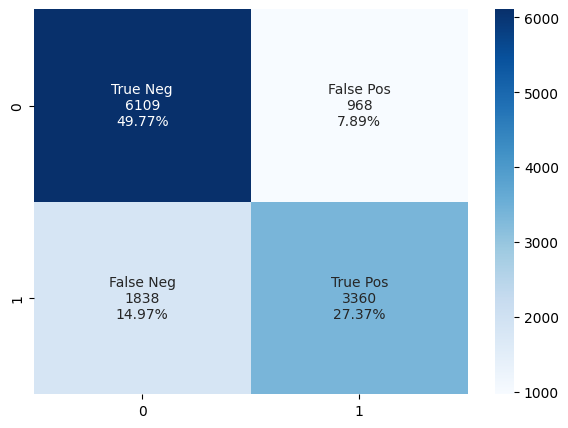

In [49]:
best_model_lgb = lgb.LGBMClassifier(**best_params)
best_model_lgb.fit(X_train_tfidf, y_train)
predictions_best_lgb = best_model_lgb.predict(X_test_tfidf)
predictions_best_proba_test = best_model_lgb.predict_proba(X_test_tfidf)[:, 1]
eval_report(y_test, predictions_best_lgb)
cm = confusion_matrix(y_test, predictions_best_lgb)
confusion_matrix_visualization(cm)

In [50]:
model_lgb.booster_.save_model('/content/gdrive/My Drive/models_fake_news/model_lgb_best.txt')

In [51]:
treshold_f1 = best_tresholds_f1(predictions_best_proba_train, y_train)
print(f'F1 score: {treshold_f1[1]:.4f}, treshold: {treshold_f1[0]}')

F1 score: 0.7358, treshold: 0.447


In [52]:
y_pred_463 = to_labels(predictions_best_proba_test, 0.426) #threshold = 0.36
metrics.f1_score(y_test, y_pred_463)

0.7022773560451767